### Introduction

Defect Analysis is a classic analysis technique to get insights into how buggy your system might be. One variant of Defect Analysis is to use an issue tracker (i.e., the system where you manage your issues) to compare the found and fixed bugs over time. With this analysis, you can find out if you

- have a spike in reported bugs (where you should investigate deeper to identify the primary sources of the bugs)
- are doing well fixing bugs (and therefore can be confident to release a stable version of your software)
- are keeping bugs at bay (to allow the implementation of new features in a more risk-free environment)

The main goal of this article is to implement this kind of analysis.

In this blog post / notebook, I'll demonstrate a Defect Analysis technique using the issues tracker system [YouTrack](https://www.jetbrains.com/youtrack/) and the defacto standard Data Science tool [pandas](https://pandas.pydata.org/) &ndash; the Python Data Analysis Library. We want to analyze the relatively new software product [Code With Me](https://plugins.jetbrains.com/plugin/14896-code-with-me) from Jetbrains (a plugin that enables you to share your locally running project from your IDE with anyone). The issues from Code With Me are managed in YouTrack, hosted by Jetbrains, and open to everyone. This allows us to use this issues tracker as our playground.

The second goal of this article is to write as less confusing analysis code as possible. I want to achieve this by using pure pandas functionality to get a readable analysis of the defects in a software system. This said, be aware that your issue tracker might bring Defect Analysis to you out of the box (YouTrack does this AFAIK). Click through the reporting features of your system before you reinvent the wheel! Nevertheless, I'll show you how you can do it on your own. There might be similar use cases to track the progress of work. In these cases, you can reuse many steps from this analysis.

*Please note: I'm not affiliated with Jetbrains. Jetbrains simply has on open issue management system where I can get some data from in an easy way. You can do this kind of analysis with any modern issues tracker system as well.*

### How to get the data
First, we have to retrieve the data we need from the issue tracker system. We can do this in various ways (direct database access, scraping the website, or using an API provided by the system). How this works depends on your tool. 

In our case, we're using [YouTrack's REST API](https://www.jetbrains.com/help/youtrack/standalone/youtrack-rest-api-reference.html) to download some data. To do this, we create an URL to get the data we need. I've dug deep into the YouTrack REST API documentation and found the information we needed to export bugs only with their creation and resolved timestamps. We also set an upper limit to the latest 1000 entries to not overload the available public issue tracker system.

In [1]:
URL = "https://youtrack.jetbrains.com/api/issues?" \
"$top=1000&"\
"fields=created,resolved&"\
"query=Type:%20Bug%20Project%3A%20%7BCode%20With%20Me%7D"

URL

'https://youtrack.jetbrains.com/api/issues?$top=1000&fields=created,resolved&query=Type:%20Bug%20Project%3A%20%7BCode%20With%20Me%7D'

In this analysis, we're using the built-in `read_json` method of pandas. The method executes a request to YouTrack. Youtrack responds with data in the JSON format. The `read_json` method parses this data and creates a DataFrame where each returned field is played into separate columns.

In [2]:
import pandas as pd
df = pd.read_json(URL)
df.head()

,resolved,created,$type
0,NaN,1612469976486,Issue
1,NaN,1612517192097,Issue
2,NaN,1612458988395,Issue
3,NaN,1612469718798,Issue
4,1.611839e+12,1611611056898,Issue


With this DataFrame (stored in the variable `df`), we can dig into a first analysis of the development of opened (the column `created`: the time a bug was created) and closed (the column `resolved`: the time where a bugfix was confirmed) bugs. First, we throw away the `$type` column because we don't need the information for our analysis.

In [3]:
defects = df[['resolved', 'created']].copy()
defects.head()

,resolved,created
0,NaN,1612469976486
1,NaN,1612517192097
2,NaN,1612458988395
3,NaN,1612469718798
4,1.611839e+12,1611611056898


### Analysis

OK, let's take a look at the development of the reported and fixed bugs. One important question we would like to answer is whether we are getting behind with bug fixing. For this, we are calculating the creation and resolution of bugs over time. That means for us that we have first to convert the corresponding data in the columns `created` and `resolved` into a data format we can calculate time with. For this, we're using the `to_datetime` method for converting the text in these columns into the  `Timestamp` data type. Because the retrieved data has a timestamp information in milliseconds since epoch (01/01/1970 00:00:00) we have to provide this information as additional parameter `unit`.

In [4]:
defects['created'] = pd.to_datetime(defects['created'], unit='ms')
defects['resolved'] = pd.to_datetime(defects['resolved'], unit='ms')
defects.head()

,resolved,created
0,NaT,2021-02-04 20:19:36.486
1,NaT,2021-02-05 09:26:32.097
2,NaT,2021-02-04 17:16:28.395
3,NaT,2021-02-04 20:15:18.798
4,2021-01-28 12:55:27.912,2021-01-25 21:44:16.898


Next, we need a model that shows us the progress of the created and fixed bugs over time. For this, we have to list all events in the timeline in one column, but to keep the information of the created and resolved bugs.

We can use the `stack()` method on the DataFrame to reorganized the multidimensional data into one continuous list of data.

In [5]:
defects_stacked = defects.stack()
defects_stacked.head()

0  created    2021-02-04 20:19:36.486
1  created    2021-02-05 09:26:32.097
2  created    2021-02-04 17:16:28.395
3  created    2021-02-04 20:15:18.798
4  resolved   2021-01-28 12:55:27.912
dtype: datetime64[ns]

This gives us a Series with a multiindex (the first two "columns": index number and the information about the bug' status) as well as the timestamp information (as `datetime64` data type) in the column `0`. We melt the first level of the multiindex with `reset_index()` to also list the status of the bug entries as normal values because we want to work with these values later on.

In [6]:
defects_list = defects_stacked.reset_index(1)
defects_list.head()

,level_1,0
0,created,2021-02-04 20:19:36.486
1,created,2021-02-05 09:26:32.097
2,created,2021-02-04 17:16:28.395
3,created,2021-02-04 20:15:18.798
4,resolved,2021-01-28 12:55:27.912


Next, we need a new column that tells us for each entry if a bug was resolved or created. We can do this by creating a new colum with the number 1 for each entry. This allows us to calculate some metrics based on this number later.

In [7]:
defects_list['count'] = 1
defects_list.head()

,level_1,0,count
0,created,2021-02-04 20:19:36.486,1
1,created,2021-02-05 09:26:32.097,1
2,created,2021-02-04 17:16:28.395,1
3,created,2021-02-04 20:15:18.798,1
4,resolved,2021-01-28 12:55:27.912,1


OK, now comes the tricky part. We have to reorder our table to get a side-by-side comparison of opened and closed bugs over time. We use the great `pivot_table` method on the DataFrame to achieve this. We set the column with the time information to our index. This gives us a time-based index and allows time series calculations. `pivot_table` also sorts the time information in the right, ascending order. As columns, we us the values of the `level_1` (= status of a bug entry) to get a side-by-side view of created and resolved bugs. Last, we use our new number column `count` to mark the activities for each bug entry at each given point of time. As a small cosmetic correction we rename the column heading from `level_1` to `defects`. We do the same for the index.

In [8]:
defects_trend = defects_list.pivot_table(
    index=0,
    columns="level_1",
    values="count",
    fill_value=0)
defects_trend.columns.name = "defects"
defects_trend.index.name = "timestamp"
defects_trend.head()

defects,created,resolved
timestamp,,
2020-06-01 16:46:48.516,1,0
2020-08-04 15:45:22.220,1,0
2020-08-27 10:35:40.693,1,0
2020-08-27 12:17:03.483,0,1
2020-08-27 14:29:18.302,1,0


Next, we want to create a trend of the created and fixed bugs. In other words, we need to track the accumulated number of open and fixed bugs for each of our timed entries. We can do this by using the `cumsum()` method on our DataFrame.

In [9]:
cumulated_defects_over_time = defects_trend.cumsum()
cumulated_defects_over_time.head()

defects,created,resolved
timestamp,,
2020-06-01 16:46:48.516,1,0
2020-08-04 15:45:22.220,2,0
2020-08-27 10:35:40.693,3,0
2020-08-27 12:17:03.483,3,1
2020-08-27 14:29:18.302,4,1


Last, we visualize this DataFrame to get a feeling about how we good (or bad) we are in managing our bugs. We're using the standard `plot` method of the DataFrame which created a line chart of your two columns: the amount of existing `created` and `resolved` bugs, plotted over time.

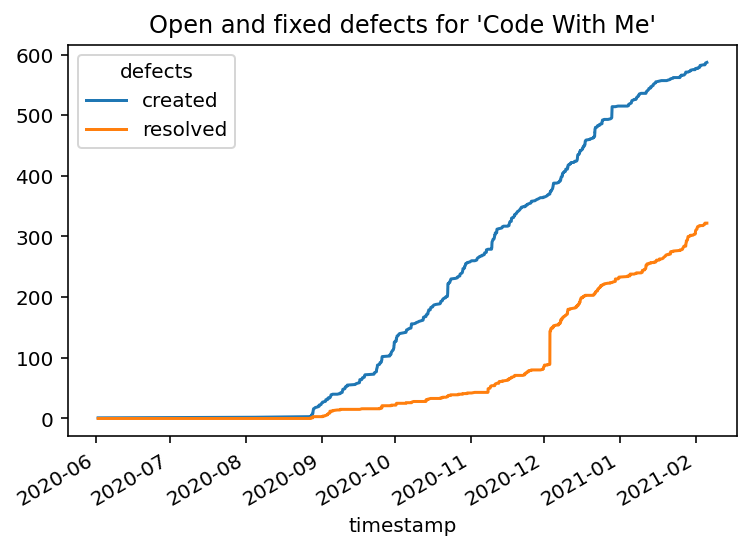

In [10]:
cumulated_defects_over_time.plot(
    title="Open and fixed defects for 'Code With Me'");

From this visualization, we can see that the team might be behind regarding fixing bugs. We also see that at the beginning of December 2020, there was a steep increase for bugfixing. It looks like someone clean up the issues tracker right before the official release, doesn't it? :-)

## Conclusion
This blog post shows guided you through a variant of Defect Analysis using the issues tracker YouTrack. The analysis gives you some hints on how you could approach analyzing your own issues tracker system (or even similiar kinds of data).

I hope you could also see that this kind of analysis isn't magic. Using appropriate standard tools like pandas helps you getting answers to your specific questions in straightforward way.